In [1]:
from pathlib import Path
import pickle
import os
import yaml
import jax

import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

from dcegm.interface import policy_for_state_choice_vec
from dcegm.pre_processing.setup_model import setup_model
from dcegm.solve import solve_dcegm

from toy_models.cons_ret_model_dcegm_paper.utility_functions_log_crra import (
    utiility_log_crra,
    utiility_log_crra_final_consume_all,
)
from toy_models.load_example_model import load_example_models


# set the jax_enable_x64 configuration option
jax.config.update("jax_enable_x64", True)

In [2]:
# Obtain the test directory of the package
TEST_DIR = Path(os.path.abspath("")).parent
REPLICATION_TEST_RESOURCES_DIR = TEST_DIR / "resources" / "replication_tests"


def load_options_and_params(model_name):
    """Return parameters and options of an example model."""
    params = yaml.safe_load(
        (REPLICATION_TEST_RESOURCES_DIR / f"{model_name}" / "params.yaml").read_text()
    )
    model_specs = yaml.safe_load(
        (REPLICATION_TEST_RESOURCES_DIR / f"{model_name}" / "options.yaml").read_text()
    )
    return params, model_specs

In [3]:
# model_name = "retirement_no_taste_shocks"
model_name = "retirement_taste_shocks"
# model_name = "deaton"

In [4]:
params, model_specs = load_options_and_params(model_name)
options = {}

options["model_params"] = model_specs
options["model_params"]["n_choices"] = model_specs["n_discrete_choices"]
options["state_space"] = {
    "n_periods": 25,
    "choices": [i for i in range(model_specs["n_discrete_choices"])],
    "continuous_states": {
        "wealth": jnp.linspace(
            0,
            options["model_params"]["max_wealth"],
            options["model_params"]["n_grid_points"],
        )
    },
}

model_funcs = load_example_models("dcegm_paper")

if model_name == "deaton":
    model_funcs["state_space_functions"] = None
    model_funcs["utility_functions"]["utility"] = utiility_log_crra
    model_funcs["final_period_utility_functions"][
        "utility"
    ] = utiility_log_crra_final_consume_all

model = setup_model(
    options=options,
    state_space_functions=model_funcs["state_space_functions"],
    utility_functions=model_funcs["utility_functions"],
    utility_functions_final_period=model_funcs["final_period_utility_functions"],
    budget_constraint=model_funcs["budget_constraint"],
)

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.



Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.

Update function for state space not given. Assume states only change with an increas

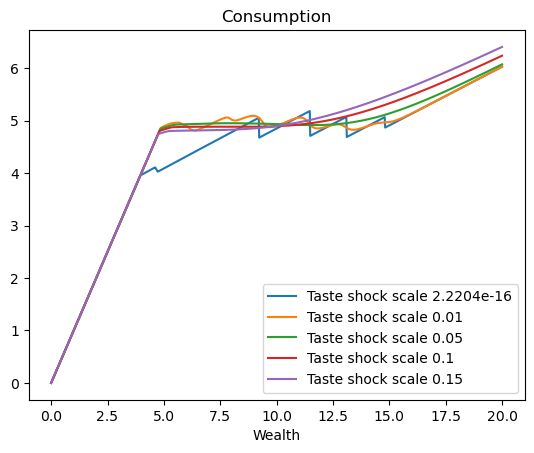

In [6]:
for taste_shock_scale in [2.2204e-16, 0.01, 0.05, 0.10, 0.15]:

    # set the taste shock scale
    params["lambda"] = taste_shock_scale

    # solve the model
    value, policy, endog_grid = solve_dcegm(
        params=params,
        options=options,
        state_space_functions=model_funcs["state_space_functions"],
        utility_functions=model_funcs["utility_functions"],
        utility_functions_final_period=model_funcs["final_period_utility_functions"],
        budget_constraint=model_funcs["budget_constraint"],
    )

    # look at the consumption policy for T-5 period, for a worker who decides to keep working (choice=0)
    test_period = options["state_space"]["n_periods"] - 5
    state_choice_dict = {
        "period": test_period,
        "lagged_choice": 0,
        "dummy_exog": 0,
        "choice": 0,
    }
    # set wealth grid for plotting
    wealth_grid = np.linspace(0, 20, 1000)

    # compute consumption policy for the wealth grid
    consumption = np.zeros_like(wealth_grid, dtype=float)
    for var_id, wealth in enumerate(wealth_grid):
        policy_interp = policy_for_state_choice_vec(
            endog_grid_solved=endog_grid,
            policy_solved=policy,
            model=model,
            state_choice_vec=state_choice_dict,
            wealth=wealth,
        )
        consumption[var_id] = policy_interp

    plt.plot(wealth_grid, consumption, label=f"Taste shock scale {taste_shock_scale}")

plt.legend()
plt.title("Consumption")
plt.xlabel("Wealth")
plt.show()